---

# 🏆 **SFPPy Example: Mass Transfer from Multilayer Materials**  
---

## ♻️ **Example 2: Mass Transfer Simulation in Recycled PP Bottles**  
------------------------------------------------------------  

### 🔍 **Overview**  
This script simulates **1D mass transfer** of **⌬ toluene** from a **📏 300 µm thick ♻️ recycled PP bottle**  
into a **🥃 fatty liquid food**. It also examines the **🔬 effect of adding a 30 µm PET functional barrier (FB)**.  

### 🛠 **Simulation Steps:**  
1️⃣ **Define bottle geometry** (🍶 1L bottle with a body and neck).  
2️⃣ **Set up polymer layers** (🛡️ PP containing toluene, with/without PET FB).  
3️⃣ **Define liquid food properties** (🫒 fatty liquid, 📦 storage conditions).  
4️⃣ **Run mass transfer simulations**:  
   - **🚫 Without a functional barrier**.  
   - **🛡️ With a 30 µm PET FB**.  
5️⃣ **Compare migration kinetics** between both cases.  
6️⃣ **Perform a systematic study** on **FB thickness** (📏 2 µm to 60 µm).  
7️⃣ **📊 Save and print all simulation results**.  

### 🎯 **Expected Outcomes:**  
✅ **Migration kinetics analysis** (with and without FB).  
✅ **Optimal PET thickness selection** 🛡️ to reduce migration.  
✅ **📈 Ready-to-use figures & 📑 reports for analysis**.  

---

📌 **Project:** SFPPy - 🛡️ SafeFoodPackaging Portal in Python Initiative  
👨‍💻 **Author:** INRAE\\olivier.vitrac@agroparistech.fr  
📜 **License:** MIT  

***

### Minimal Setup for SFPPy Core 🚀🔧⚙️

> This setup is designed to work on any machine – whether SFPPy is already installed or not.  

<details>
    <summary>Click to Expand</summary>
  
> The cell attempts to import the core module `patankar.loadpubchem`.  
> - If it **succeeds**, SFPPy is already initialized, and no further action is needed.  
> - If it **fails**, the cell will try to run the initialization script `initialize_sfppy.py` (searched from several candidate paths).  
>   - If the script is found, it will be executed.  
>   - If not, the repository will be cloned (or refreshed) and then initialized.
>  
> After successful initialization, the full path to the SFPPy installation folder is displayed.  
>  
> **Note:** Make sure you are in a directory with access to SFPPy (or that can clone it). In a read-only environment, this cell will help you set up SFPPy temporarily.

</details>

In [3]:
import sys, os
import ipywidgets as widgets
from IPython.display import display, HTML

verbose = True  # Set verbosity flag
clone = True # True enable cloning from GitHub repo

try:
    import patankar.loadpubchem
    if verbose: print("✅ SFPPy is already initialized; skipping initialization.")
except ImportError:
    if verbose: print("⚠️ SFPPy not detected; attempting initialization.")
    base_dirs = ["./SFPPy/utils", "../utils", "./utils", ".", "../../utils", "../../../utils"]
    # Find candidates for the initialization script in various base directories.
    candidates = [os.path.abspath(os.path.join(d, "initialize_sfppy.py"))
                  for d in base_dirs if os.path.exists(os.path.join(d, "initialize_sfppy.py"))]
    if candidates:
        if verbose: print(f"🔍 Running initialization script: {candidates[0]}")
        %run -i {candidates[0]} --no-verbose --no-cd
        try:
            import patankar.loadpubchem
            if verbose: print("✅ SFPPy successfully initialized.")
        except ImportError: print("❌ ERROR: Initialization failed; 'patankar.loadpubchem' is still unavailable.\n", "Current sys.path:\n", sys.path)
    elif clone:
        if not os.path.exists("SFPPy"):
            if verbose: print("📥 SFPPy repository not found. Cloning the repository – please be patient.")
            !git clone https://github.com/ovitrac/SFPPy.git  # First time: clone the repository
        else:
            if verbose: print("🔄 Refreshing the SFPPy repository.")
            !git -C SFPPy pull  # Subsequent times: update the repository if needed
        %cd SFPPy
        installationscript = os.path.abspath(os.path.join(os.getcwd(), "utils", "initialize_sfppy.py"))
        %run -i {installationscript} --no-verbose --no-cd
        try:
            import patankar.loadpubchem
            if verbose:
                print("✅ SFPPy successfully initialized.")
        except ImportError: print("❌ ERROR: Initialization failed; 'patankar.loadpubchem' is still unavailable.\n", "Current sys.path:\n", sys.path)
    else:
        raise FileNotFoundError("❌ ERROR: Either set clone=True or start the notebook from a valid SFPPy installation.\n")

SFPPymainfolder = os.path.abspath(os.path.join(os.path.dirname(patankar.loadpubchem.__file__), ".."))
print("📁 SFPPy installation folder:", SFPPymainfolder)
from utils.nbutils import create_header_footer   # SFPPy utilities for notebooks
(header,footer,separator) = create_header_footer(title="SFPPy - Notebook 📑",what="all"); display(header)

⚠️ SFPPy not detected; attempting initialization.
🔍 Running initialization script: /home/olivi/natacha/python/utils/initialize_sfppy.py
✅ SFPPy successfully initialized.
📁 SFPPy installation folder: /home/olivi/natacha/python


### **Dependencies**

In [5]:
import os
from patankar.loadpubchem import migrant    # Migrant online database
from patankar.geometry import Packaging3D   # 3D geometry module
import patankar.food as food                # Food contact classes
import patankar.layer as polymer            # Polymer database
from patankar.migration import senspatankar as solver # Mass transfer solver
from patankar.migration import CFSimulationContainer as store # Store results
from patankar.migration import print_figure # Printing functions
from patankar.layer import _toSI            # Convert units to SI

import matplotlib.pyplot as plt

***

## 1 | **Reference migration conditions**

### 1.1 | **Define the output directory to store results**

In [8]:
outputfolder = os.path.join(os.getcwd(), "tmp")
os.makedirs(outputfolder, exist_ok=True)  # Create folder if missing

***
### 1.2 | Store numbers with their units in a tuple

In [10]:
contactTemperature = (20, "degC")
contactTime = (450, "days")  # Contact duration in days

***
### 1.3 | ⚠️ Note: Concentrations have arbitrary units. Final results maintain the same units.

In [12]:
maxConcentration = 10  # Maximum initial concentration in the polymer (mg/kg)

***

### 1.4 | **Create a **1L bottle** by assembling two cylinders**
- **body**
-  and **neck**.

The geometry is defined using the `Packaging3D` class.

In [14]:
bottle = Packaging3D(
    "bottle",
    body_radius=(40, "mm"),  # 40 mm body radius
    body_height=(0.2, "m"),  # 20 cm body height
    neck_radius=(1.8, "cm"),  # 1.8 cm neck radius
    neck_height=0.05          # 5 cm neck height (default SI unit: meters)
)

# Compute internal volume (m³) and contact surface area (m²)
internalvolume, contactsurface = bottle.get_volume_and_area()

***

### 1.5 | **Retrieve chemical properties of the migrant (toluene)**

In [16]:
surrogate = migrant("toluene")
# Display surrogate details
repr(surrogate)

⚠️Warning: No 🇪🇺10/2011/EC record found for PubChem cid 1140.
<migrant object>
    Compound: toluene
        Name: ['NCGC00258776-01',  [...] 2', 'Phenylmethane']
         cid: 1140
         CAS: ['25013-04-1', '108-88-3']
     M (min): 92.14
     M_array: [92.14]
     formula: C7H8
      smiles: CC1=CC=CC=C1
    InChiKey: YXFVVABEGXRONW-UHFFFAOYSA-N
        logP: [2.7]
   P' (calc): [1.23097093]


'<migrant: NCGC00258776-01 - M=92.14 g/mol>'

***

### 1.6 | **Create bottle walls**
Create a **300 µm thick PP layer** containing **toluene** at the initial concentration

In [18]:
PPwalls_with_toluene = polymer.PP(
    l=(300, "um"),    # Thickness: 300 µm
    substance=surrogate,
    C0=maxConcentration,  # Initial concentration in PP
    T=contactTemperature  # Temperature of contact
)
# Display bottle walls
repr(PPwalls_with_toluene)


[LAYER object version=1, contact=olivier.vitrac@agroparistech.fr]
monolayer of LAYER object:
-- [ layer 1 of 1 ] ---------- barrier rank=1 --------------
      name: "layer in PP"
      type: "polymer"
  material: "isotactic polypropylene"
      code: "PP"
   crystal: 0.5
        Tg: 0 [degC]
         l: 0.0003 [meter]
         D: 6.161e-14 [m**2/s]
          = Dpiringer(PP,<migrant: NCGC00258776-01 - M=92.14 g/mol>,T=20.0 degC)
         k: 1.106 [a.u.]
          = kFHP(<propylene>,<migrant: NCGC00258776-01 - M=92.14 g/mol>)
        C0: 10 [a.u.]
         T: 20 [degC]


"<PP with 1 layer: ['layer in PP']>"

***

### 1.7 | Define a **fatty liquid food** using multiple inheritance from:
- `food.realfood`,
- `food.liquid`, 
- and `food.fat`.

In [20]:
class liquidFood(food.realfood, food.liquid, food.fat):
    name = "liquidFood"

# Instantiate the liquid food layer
FOODlayer = liquidFood(
    volume=internalvolume,
    surfacearea=contactsurface,
    contacttime=contactTime,
    contacttemperature=contactTemperature
)
# Display the food 'layer"
print(repr(FOODlayer)); display(separator)

Food object "liquidFood" (real food class) with properties:
               CF0: 0 [a.u.]
contacttemperature: 20 [degC]
       contacttime: 38880000 [s]
           density: 1000 [kilogram / meter ** 3]
                 h: 1e-06 [meter / second]
       surfacearea: 0.065973446 [meter ** 2]
            volume: 0.0010562035 [meter ** 3]
<liquidFood: liquidFood>


## 2 |  **Reference simulation**

### 2.1 | Simulate migration for the bottle **without a functional barrier**.

In [22]:
ref_simulation = solver(
    PPwalls_with_toluene,  # PP walls containing toluene
    FOODlayer,             # Fatty liquid food
    name="bottle-rPP"
)
repr(ref_simulation)

SensPatankarResult: bottle-rPP
	 <no description>
	 - with 1000 time steps
 	 - with 1800 spatial points
	 - Time range: [0.00e+00, 7.78e+07] s
	 - Position range: [0.00e+00, 3.00e-04] m


'<SensPatankarResult:bottle-rPP: CF(450 [days]) = 0.1843 [a.u.]>'

***

### 2.2 | **Concentration profiles at the final contact time**

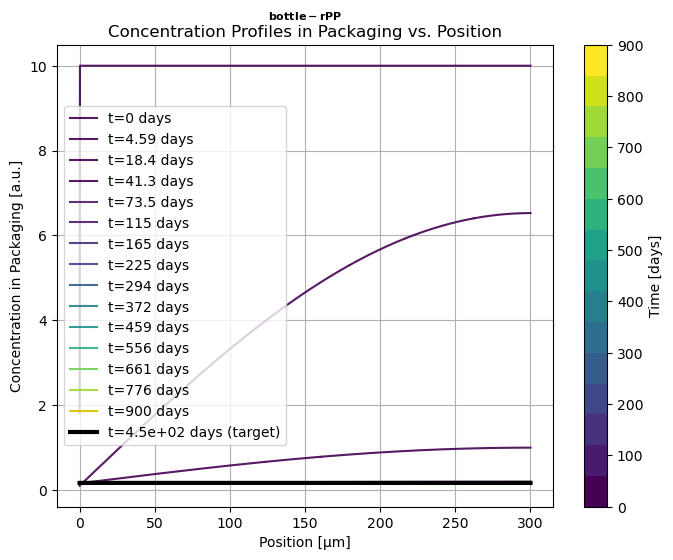

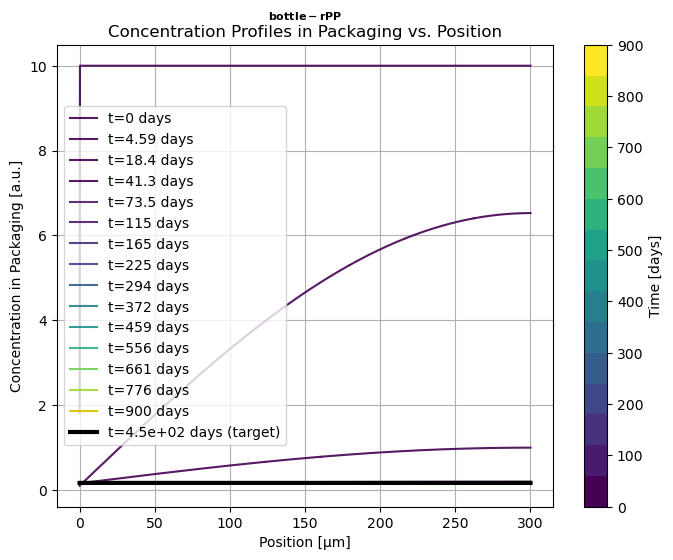

In [24]:
ref_simulation.plotCx()

***

### 2.3 | **Migration kinetics (CF vs time) for selected time points**

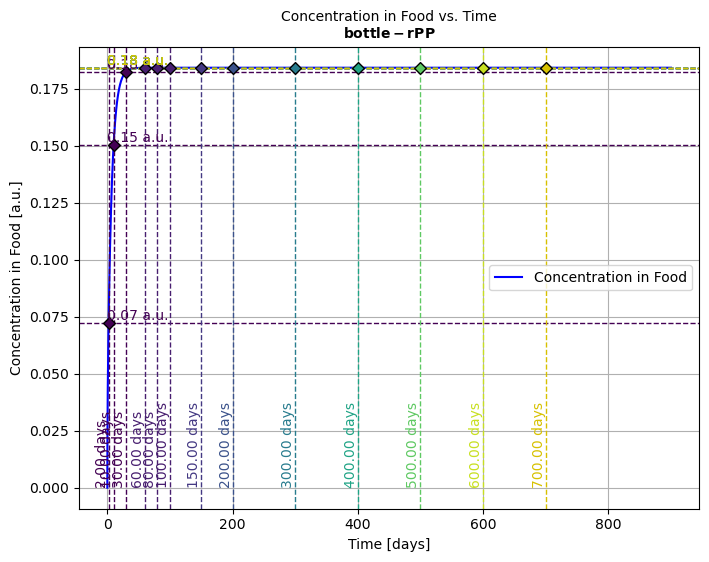

In [26]:
listoftimes = _toSI(([2,10,30,60,80,100,150,200,300,400,500,600,700], "days"))
hfig1 = ref_simulation.plotCF(t=listoftimes)
display(separator)

## 3 | **Migration problem with a functional barrier**

### 3.1 | Create a **30 µm thick PET layer** as a functional barrier

Two options are available for the function barrier:
- without plasticizing effects, then use `gPET` (glassy and unplasticized PET)
- with plasticizing effects, then use `wPET` (plasticized PET)

> Note:
> For toluene as surrogate, SFFPy uses the most reliable diffusivity model (DFV), which covers the plasticizing effects of water, ethanol and esters.
> For other surrogates in `gPET`, SFPPy uses the revised model of Frank Welle (Dwelle), which works well for dry PET.

In [30]:
# functional barrier (wet) = plasticized
PET_functionalBarrier_dry = polymer.gPET(  
    l=(30, "um"),  # Thickness: 30 µm
    substance=surrogate,
    C0=0,  # Virgin PET (no migrant initially)
    T=contactTemperature
)
repr(PET_functionalBarrier_dry)

# functional barrier (wet) = plasticized
PET_functionalBarrier_wet = polymer.wPET(  
    l=(30, "um"),  # Thickness: 30 µm
    substance=surrogate,
    C0=0,  # Virgin PET (no migrant initially)
    T=contactTemperature
)
# Display the barrier
repr(PET_functionalBarrier_wet)


[LAYER object version=1, contact=olivier.vitrac@agroparistech.fr]
monolayer of LAYER object:
-- [ layer 1 of 1 ] ---------- barrier rank=1 --------------
      name: "layer in gPET"
      type: "polymer"
  material: "glassy PET"
      code: "PET"
   crystal: 0.35
        Tg: 76 [degC]
         l: 3e-05 [meter]
         D: 2.936e-21 [m**2/s]
          = DFV(gPET,<migrant: NCGC00258776-01 - M=92.14 g/mol>,T=20.0 degC)
         k: 0.565 [a.u.]
          = kFHP(<ethylene terephthalate>,<migrant: NCGC00258776-01 - M=92.14 g/mol>)
        C0: 0 [a.u.]
         T: 20 [degC]

[LAYER object version=1, contact=olivier.vitrac@agroparistech.fr]
monolayer of LAYER object:
-- [ layer 1 of 1 ] ---------- barrier rank=1 --------------
      name: "layer in wPET"
      type: "polymer"
  material: "plasticized PET"
      code: "PET"
   crystal: 0.35
        Tg: 46 [degC]
         l: 3e-05 [meter]
         D: 1.682e-16 [m**2/s]
          = DFV(wPET,<migrant: NCGC00258776-01 - M=92.14 g/mol>,T=20.0 degC)

"<wPET with 1 layer: ['layer in wPET']>"

***

### 3.2 | **Combine PET and PP layers (Food is on the left, PET is the outermost layer)**

In [32]:
FBwalls_with_toluene_dry = PET_functionalBarrier_dry + PPwalls_with_toluene # bottle with dry FB
FBwalls_with_toluene_wet = PET_functionalBarrier_wet + PPwalls_with_toluene # bottle with wet FB
# Display the assembly (only the wet assembly is shown)
print(repr(FBwalls_with_toluene_wet)); display(separator)


[LAYER object version=1, contact=olivier.vitrac@agroparistech.fr]
2-multilayer of LAYER object:
-- [ layer 1 of 2 ] ---------- barrier rank=1 --------------
      name: "layer in wPET"
      type: "polymer"
  material: "plasticized PET"
      code: "PET"
   crystal: 0.35
        Tg: 46 [degC]
         l: 3e-05 [meter]
         D: 1.682e-16 [m**2/s]
          = DFV(wPET,<migrant: NCGC00258776-01 - M=92.14 g/mol>,T=20.0 degC)
         k: 0.565 [a.u.]
          = kFHP(<ethylene terephthalate>,<migrant: NCGC00258776-01 - M=92.14 g/mol>)
        C0: 0 [a.u.]
         T: 20 [degC]
-- [ layer 2 of 2 ] ---------- barrier rank=2 --------------
      name: "layer in PP"
      type: "polymer"
  material: "isotactic polypropylene"
      code: "PP"
   crystal: 0.5
        Tg: 0 [degC]
         l: 0.0003 [meter]
         D: 6.161e-14 [m**2/s]
          = Dpiringer(PP,<migrant: NCGC00258776-01 - M=92.14 g/mol>,T=20.0 degC)
         k: 1.106 [a.u.]
          = kFHP(<propylene>,<migrant: NCGC00258776-

## 4. | Simulate migration with **PET Functional Barrier**

### 4.1 | **Run the simulation**

In [35]:
# simulation with a wet functional barrier
fb_simulation_dry = solver(
    FBwalls_with_toluene_dry,
    FOODlayer,
    name="bottleFB-PET-rPP"
)

# simulation with a wet functional barrier
fb_simulation_wet = solver(
    FBwalls_with_toluene_wet,
    FOODlayer,
    name="bottleFB-PET-rPP"
)
# display the last simulation
repr(fb_simulation_wet)

SensPatankarResult: bottleFB-PET-rPP
	 <no description>
	 - with 1000 time steps
 	 - with 1800 spatial points
	 - Time range: [0.00e+00, 7.78e+07] s
	 - Position range: [0.00e+00, 3.30e-04] m


'<SensPatankarResult:bottleFB-PET-rPP: CF(450 [days]) = 0.134 [a.u.]>'

***

### 4.2 Concentration profiles at final time

> Observe the drastic differences in concentration profiles in the presence of a plasticizing effect.

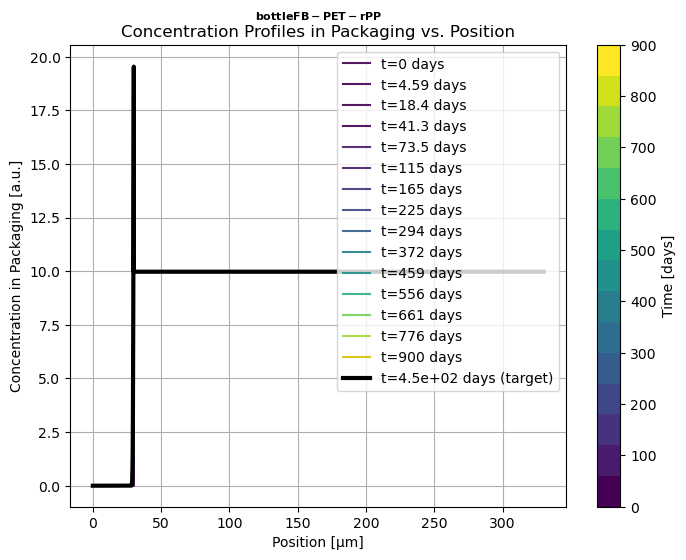

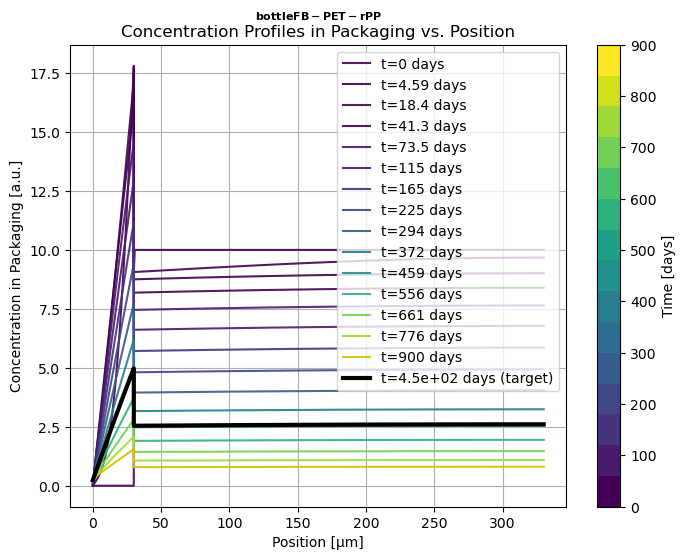

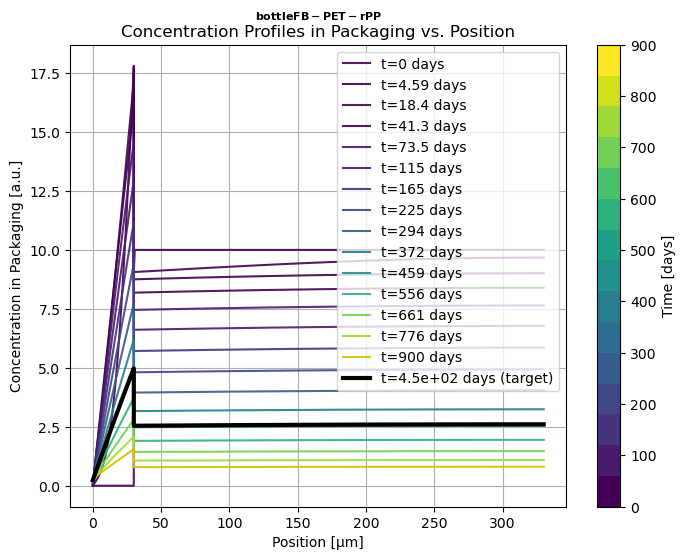

In [38]:
fb_simulation_dry.plotCx()
fb_simulation_wet.plotCx()

***

### 4.3 | **Migration kinetics (CF vs time)**

> The differences are even more obvious on kinetics in food simulant

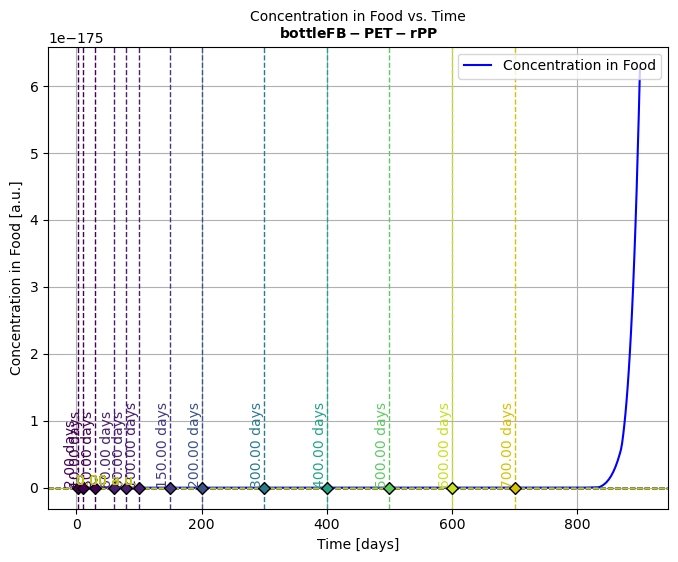

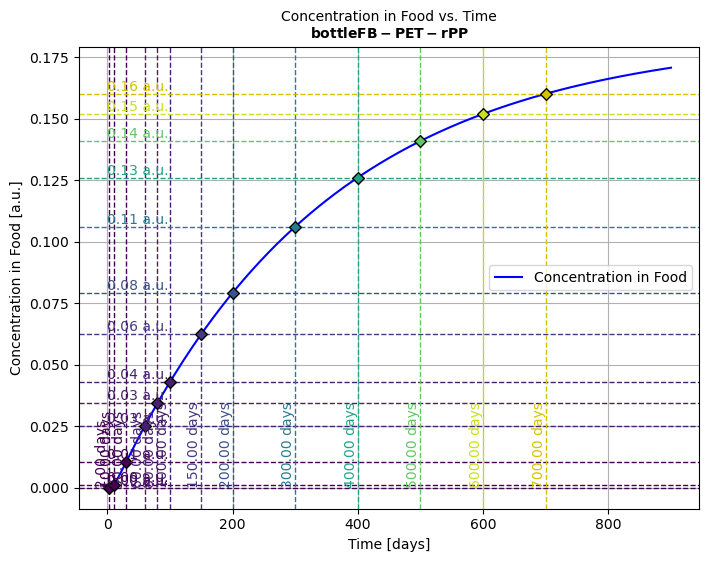

In [41]:
hfig2dry = fb_simulation_dry.plotCF(t=listoftimes)
hfig2wet = fb_simulation_wet.plotCF(t=listoftimes)

***

### 4.4 | **Store and compare simulations**

Three cases:
- without functional barrier
- with a functional barrier remaining dry all the time
- with a functional barrier which is strongly plasticized

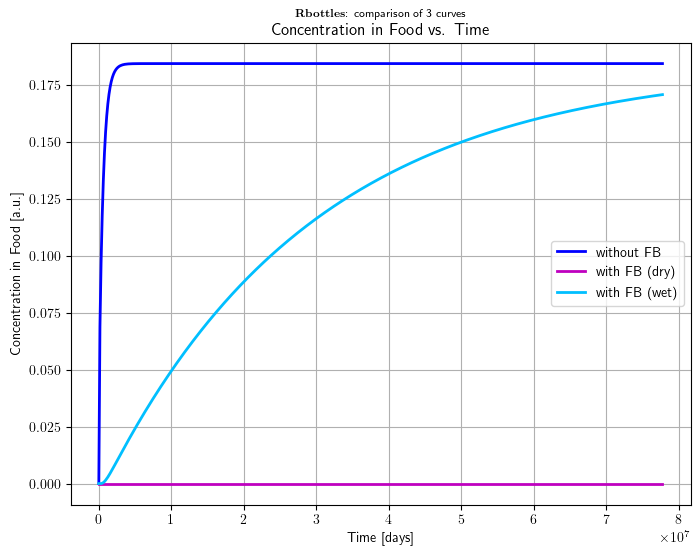

In [44]:
allCF = store(name="Rbottles")
allCF.add(ref_simulation, "without FB", "b")  # Reference case (blue)
allCF.add(fb_simulation_dry, "with FB (dry)", "m")            # Dry functional barrier case (magenta)
allCF.add(fb_simulation_wet, "with FB (wet)", "deepskyblue")  # Wet functional barrier case (deepskyblue)
hfig12 = allCF.plotCF()
display(separator)

## 5 | **Sensitivity analysis: effect of the functional barrier thickness**

Evaluate migration reduction by **varying the PET barrier thickness** from **2 µm to 60 µm**
(step of 4 µm). The results are stored in `fullcomparison`.

> The sensitivity analysis is based on the `wet` case

Solving for FB = 2 µm
Solving for FB = 6 µm
Solving for FB = 10 µm
Solving for FB = 14 µm
Solving for FB = 18 µm
Solving for FB = 22 µm
Solving for FB = 26 µm
Solving for FB = 30 µm
Solving for FB = 34 µm
Solving for FB = 38 µm
Solving for FB = 42 µm
Solving for FB = 46 µm
Solving for FB = 50 µm
Solving for FB = 54 µm
Solving for FB = 58 µm


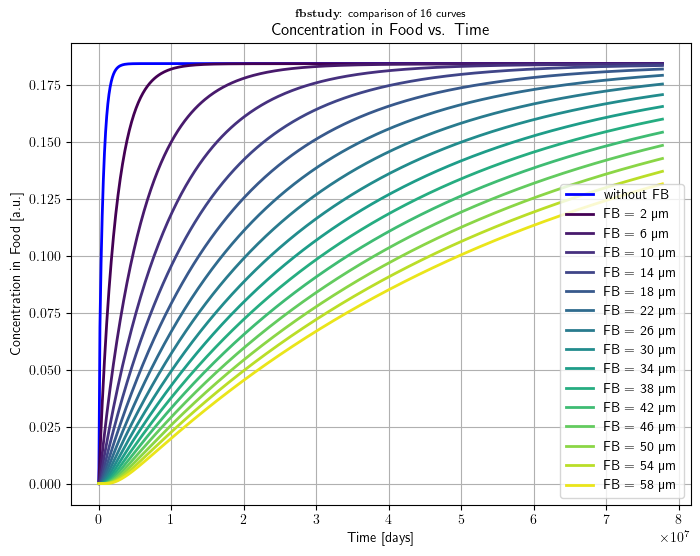

In [46]:
fullcomparison = store(name="fb study")
fullcomparison.add(ref_simulation, "without FB", "b")  # Add reference case

# Copy the FB configuration to modify thickness
currentfb_walls = FBwalls_with_toluene_wet.copy() # use FBwalls_with_toluene_dry instead if you want

# Iterate over thickness values from 2 µm to 60 µm in steps of 4 µm
for fb_thickness in range(2, 61, 4):
    print(f"Solving for FB = {fb_thickness} µm")

    # Update PET layer thickness (Layer 0 is the FB)
    currentfb_walls.l[0] = _toSI((fb_thickness, "um")).item()

    # Run simulation for the current FB thickness
    currentfb_simulation = solver(
        currentfb_walls,
        FOODlayer,
        name=f"bottleFB-PET-{fb_thickness}um"
    )

    # Assign a unique color for each thickness
    color = plt.cm.viridis((fb_thickness - 2) / (60 - 2))
    fullcomparison.add(currentfb_simulation, f"FB = {fb_thickness} µm", color)

# Plot migration kinetics for all FB thicknesses
hfig_all = fullcomparison.plotCF()
display(separator)

## 6 | Print figures if they're available in QT
> Embedded figures cannot be printed; they are already static.

In [48]:
printconfig = {"destinationfolder": outputfolder, "overwrite": True}
print_figure(hfig1, **printconfig)
print_figure(hfig2dry, **printconfig)
print_figure(hfig2wet, **printconfig)
print_figure(hfig12, **printconfig)
print_figure(hfig_all, **printconfig)
display(separator, footer)

no valid figure
no valid figure
no valid figure
no valid figure
no valid figure
